In [1]:
from nltk import word_tokenize, pos_tag
import pandas as pd
import re
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def is_word_appearing_in_the_from(word, line):
    if 'from' in line.lower() and word.lower().strip() != 'from':
        return True
    else:
        return False
    
def followed_by_and_I(word, context):
    # if word is followed by "and I" return true, else false.
    context = context.lower()
    word = word.lower()
    if context.count(f"and i {word}") > 0:
        return True
    else:
        return False
    
def is_word_capitalized(word):
    return word[0].isupper()


def custom_word_tokenize(text): # need <true_name> labels within my tokens to know if its a name or not
    name_pattern = r'<true_name>.*?</true_name>'

    name_matches = re.finditer(name_pattern, text)

    tokens = []
    start_idx = 0
    for match in name_matches:
        tokens.extend(word_tokenize(text[start_idx:match.start()]))
        tokens.append(match.group())
        start_idx = match.end()

    tokens.extend(word_tokenize(text[start_idx:]))

    return tokens

In [3]:
train_path = "datasets/NewsGroups-XML/train"
news_groups_train_folders = os.listdir(train_path)

sentences = []
from_features = []
labels = []
bigram_features = []
capitalized_features = []

for folder in news_groups_train_folders:
    for file in os.listdir(f"{train_path}/{folder}"):
        file_path = f"{train_path}/{folder}/{file}"
        print(f"Processing file at {file_path}...")
        lines = []
        all_context = ""
        with open(file_path, mode="r+") as f:
            for line in f.readlines():
                if line.strip() != "":
                    lines.append(line.strip())
                    all_context += line.strip() + " "
        
        for line in lines:
            ex_sentence = line
            ex_sentence = ex_sentence.replace("<true_name> ", "<true_name>")
            ex_sentence = ex_sentence.replace(" </true_name>", "</true_name>")
            #print(ex_sentence)
            word_tags = pos_tag(custom_word_tokenize(ex_sentence))
            #print(word_tags)
            # process the line, don't take unnecessary words to the training.
            processed_sentence = []
            is_from_feature = []
            is_name_label = []
            bigram_feature = []
            capitalize_feature = []
        
            for word, tag in word_tags:
                #print(word, tag, tag == '.')
                if not (tag == '.' or tag == ':' or tag == ')' or tag == '(' or word == '*' or word.count('.')>1 or word == '``'):
                    if not word.endswith('.com'):
                        if not '@' in word:
                            if '<true_name>' in word:
                                new_word = word.replace("<true_name>", "")
                                new_word = new_word.replace("</true_name>", "")
                                new_word = new_word.strip()
                                for name in new_word.split(" "):
                                    if name.isalpha():
                                        #print(name, name.isalpha(), is_word_appearing_in_the_from(name, ex_sentence), "is_name")
                                        processed_sentence.append(name)
                                        is_from_feature.append(1 if is_word_appearing_in_the_from(name, ex_sentence) else 0)
                                        is_name_label.append(1)
                                        bigram_feature.append(1 if followed_by_and_I(name, all_context) else 0)
                                        capitalize_feature.append(1 if is_word_capitalized(name) else 0)
                            else:
                                #print(word, word.isalpha(), is_word_appearing_in_the_from(word, ex_sentence))
                                processed_sentence.append(word)
                                is_from_feature.append(1 if is_word_appearing_in_the_from(word, ex_sentence) else 0)
                                is_name_label.append(0)
                                bigram_feature.append(1 if followed_by_and_I(word, all_context) else 0)
                                capitalize_feature.append(1 if is_word_capitalized(word) else 0)
        
            bigram_features.append(bigram_feature)
            labels.append(is_name_label)
            sentences.append(processed_sentence)
            from_features.append(is_from_feature)
            capitalized_features.append(capitalize_feature)

Processing file at datasets/NewsGroups-XML/train/bunch1/10112...
Processing file at datasets/NewsGroups-XML/train/bunch1/10168...
Processing file at datasets/NewsGroups-XML/train/bunch1/10602...
Processing file at datasets/NewsGroups-XML/train/bunch1/10650...
Processing file at datasets/NewsGroups-XML/train/bunch1/10792...
Processing file at datasets/NewsGroups-XML/train/bunch1/10818...
Processing file at datasets/NewsGroups-XML/train/bunch1/10830...
Processing file at datasets/NewsGroups-XML/train/bunch1/10848...
Processing file at datasets/NewsGroups-XML/train/bunch1/10905...
Processing file at datasets/NewsGroups-XML/train/bunch1/10935...
Processing file at datasets/NewsGroups-XML/train/bunch1/15225...
Processing file at datasets/NewsGroups-XML/train/bunch1/15260...
Processing file at datasets/NewsGroups-XML/train/bunch1/15324...
Processing file at datasets/NewsGroups-XML/train/bunch1/15364...
Processing file at datasets/NewsGroups-XML/train/bunch1/15423...
Processing file at datase

In [4]:
# find features for every word in the e-mail sentences.
len(sentences)

16967

In [5]:
words = []
is_capital_feature = []
is_in_from_feature = []
is_bigram_feature = []
real_labels = []

for sentence_index, sentence in enumerate(sentences):
    for i, word in enumerate(sentence):
        words.append(word)
        is_capitalized = capitalized_features[sentence_index][i]
        is_capital_feature.append(is_capitalized)
        
        y = labels[sentence_index][i]
        real_labels.append(y)
        
        is_bigram = bigram_features[sentence_index][i]
        is_bigram_feature.append(is_bigram)
        
        is_from = from_features[sentence_index][i]
        is_in_from_feature.append(is_from)
        
        
    

In [6]:
assert len(words) == len(is_capital_feature) == len(is_in_from_feature) == len(real_labels) == len(is_bigram_feature)

In [7]:
# percentages of the features' existances in the training data
np.array(real_labels).mean(), np.array(is_capital_feature).mean(), np.array(is_in_from_feature).mean(), np.array(is_bigram_feature).mean()

(0.025897229845496035,
 0.22948160053371341,
 0.03959637923976165,
 0.0013039588798083484)

In [8]:
word_to_index = {"<PAD>":0}
for word in words:
    if word not in word_to_index.keys():
        word_to_index[word] = len(word_to_index)

In [9]:
len(word_to_index)

19923

In [10]:
X_indices = [word_to_index[word] for word in words]
X_padded = torch.tensor(X_indices)
y_tensor = torch.tensor(real_labels, dtype=torch.float32)
is_capital_tensor = torch.tensor(is_capital_feature, dtype=torch.float32)
is_in_from_tensor = torch.tensor(is_in_from_feature, dtype=torch.float32)
is_bigram_tensor = torch.tensor(is_bigram_feature, dtype=torch.float32)

In [121]:
class LSTMModelWithFeatures(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size):
        super(LSTMModelWithFeatures, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim + 3, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, capital, from_field, bigram):
        word_embeddings = self.embedding(x)

        # Create tensors for additional featuresS
        capital_feature = torch.unsqueeze(capital, dim=-1).float()
        from_field_feature = torch.unsqueeze(from_field, dim=-1).float()
        bigram_feature = torch.unsqueeze(bigram, dim=-1).float()

        # Concatenate all features with word embeddings
        combined_features = torch.cat([word_embeddings, capital_feature, from_field_feature, bigram_feature], dim=-1)

        lstm_out, _ = self.lstm(combined_features)
        output = self.fc(lstm_out)  # Assuming you want to use the last time step's output
        output = self.sigmoid(output)
        return output

In [156]:
# Calculate class weights
positive_class_weight = len(y_tensor) / (y_tensor.sum() + 1e-5)  # Avoid division by zero
negative_class_weight = 1.0

print(positive_class_weight, negative_class_weight)
# Create a weight tensor for the BCEWithLogitsLoss
class_weights = []
for i, y in enumerate(y_tensor):
    if y == 1:
        class_weights.append(1*positive_class_weight*2)
    else:
        class_weights.append(1)
        
class_weights = torch.tensor(class_weights)
# Hyperparameters
vocab_size = len(word_to_index)
embedding_dim = 50
hidden_size = 256
output_size = 1

# Create the model and move it to CUDA
model_with_features = LSTMModelWithFeatures(vocab_size, embedding_dim, hidden_size, output_size)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss(weight=class_weights)
optimizer = optim.Adam(model_with_features.parameters(), lr=0.001)

tensor(38.6142) 1.0


In [137]:
len(y_tensor)

131906

In [157]:
losses = []
accuracies = []
# Training loop
epochs = 30
for epoch in range(epochs):
    # Forward pass
    outputs = model_with_features(X_padded, is_capital_tensor, is_in_from_tensor, is_bigram_tensor)

    # Compute loss
    loss = criterion(outputs.squeeze(), y_tensor.float())

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    accuracy = ((outputs > 0.5).squeeze().float() == y_tensor).float().mean()
    accuracies.append(accuracy)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, accuracy: {accuracy:.4f}')

Epoch [1/30], Loss: 1.8970, accuracy: 0.7663
Epoch [2/30], Loss: 1.8918, accuracy: 0.6410
Epoch [3/30], Loss: 1.8864, accuracy: 0.5321
Epoch [4/30], Loss: 1.8805, accuracy: 0.4577
Epoch [5/30], Loss: 1.8737, accuracy: 0.4048
Epoch [6/30], Loss: 1.8657, accuracy: 0.3648
Epoch [7/30], Loss: 1.8557, accuracy: 0.3308
Epoch [8/30], Loss: 1.8431, accuracy: 0.2973
Epoch [9/30], Loss: 1.8267, accuracy: 0.2586
Epoch [10/30], Loss: 1.8075, accuracy: 0.2072
Epoch [11/30], Loss: 1.8300, accuracy: 0.1054
Epoch [12/30], Loss: 1.7919, accuracy: 0.2186
Epoch [13/30], Loss: 1.7841, accuracy: 0.3088
Epoch [14/30], Loss: 1.7801, accuracy: 0.3793
Epoch [15/30], Loss: 1.7757, accuracy: 0.4357
Epoch [16/30], Loss: 1.7702, accuracy: 0.4813
Epoch [17/30], Loss: 1.7637, accuracy: 0.5184
Epoch [18/30], Loss: 1.7562, accuracy: 0.5504
Epoch [19/30], Loss: 1.7478, accuracy: 0.5781
Epoch [20/30], Loss: 1.7387, accuracy: 0.6035
Epoch [21/30], Loss: 1.7292, accuracy: 0.6279
Epoch [22/30], Loss: 1.7194, accuracy: 0.65

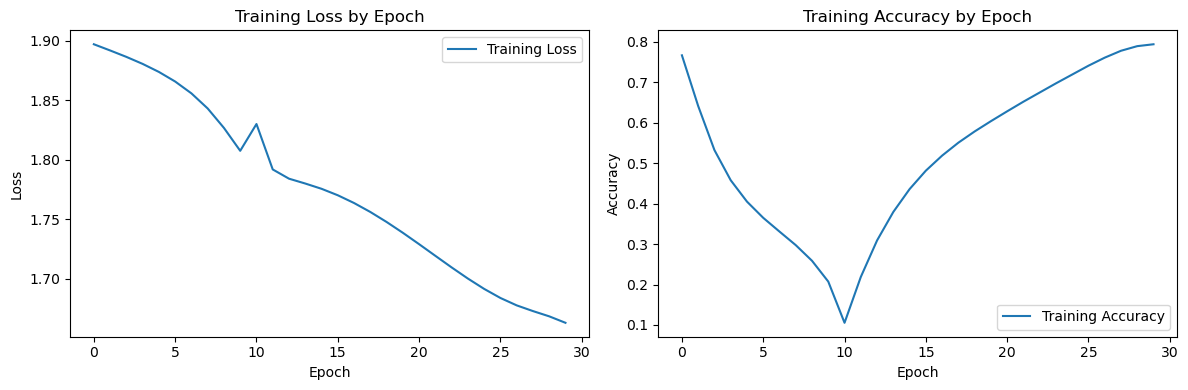

In [158]:
# Plotting
plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss by Epoch')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy by Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [159]:
test_path = "datasets/NewsGroups-XML/test"
news_groups_test_folders = os.listdir(test_path)

test_sentences = []
test_from_features = []
test_labels = []
test_bigram_features = []
test_capitalized_features = []

for folder in news_groups_test_folders:
    for file in os.listdir(f"{test_path}/{folder}"):
        file_path = f"{test_path}/{folder}/{file}"
        print(f"Processing test email file at {file_path}...")
        lines = []
        all_context = ""
        with open(file_path, mode="r+") as f:
            for line in f.readlines():
                if line.strip() != "":
                    lines.append(line.strip())
                    all_context += line.strip() + " "

        for line in lines:
            ex_sentence = line
            ex_sentence = ex_sentence.replace("<true_name> ", "<true_name>")
            ex_sentence = ex_sentence.replace(" </true_name>", "</true_name>")
            #print(ex_sentence)
            word_tags = pos_tag(custom_word_tokenize(ex_sentence))
            #print(word_tags)
            # process the line, don't take unnecessary words to the training.
            processed_sentence = []
            is_from_feature = []
            is_name_label = []
            bigram_feature = []
            capitalize_feature = []

            for word, tag in word_tags:
                #print(word, tag, tag == '.')
                if not (tag == '.' or tag == ':' or tag == ')' or tag == '(' or word == '*' or word.count('.')>1 or word == '``'):
                    if not word.endswith('.com'):
                        if not '@' in word:
                            if '<true_name>' in word:
                                new_word = word.replace("<true_name>", "")
                                new_word = new_word.replace("</true_name>", "")
                                new_word = new_word.strip()
                                for name in new_word.split(" "):
                                    if name.isalpha():
                                        #print(name, name.isalpha(), is_word_appearing_in_the_from(name, ex_sentence), "is_name")
                                        processed_sentence.append(name)
                                        is_from_feature.append(1 if is_word_appearing_in_the_from(name, ex_sentence) else 0)
                                        is_name_label.append(1)
                                        bigram_feature.append(1 if followed_by_and_I(name, all_context) else 0)
                                        capitalize_feature.append(1 if is_word_capitalized(name) else 0)
                            else:
                                #print(word, word.isalpha(), is_word_appearing_in_the_from(word, ex_sentence))
                                processed_sentence.append(word)
                                is_from_feature.append(1 if is_word_appearing_in_the_from(word, ex_sentence) else 0)
                                is_name_label.append(0)
                                bigram_feature.append(1 if followed_by_and_I(word, all_context) else 0)
                                capitalize_feature.append(1 if is_word_capitalized(word) else 0)

            test_bigram_features.append(bigram_feature)
            test_labels.append(is_name_label)
            test_sentences.append(processed_sentence)
            test_from_features.append(is_from_feature)
            test_capitalized_features.append(capitalize_feature)






Processing test email file at datasets/NewsGroups-XML/test/bunch3b/67213...
Processing test email file at datasets/NewsGroups-XML/test/bunch3b/67266...
Processing test email file at datasets/NewsGroups-XML/test/bunch3b/67278...
Processing test email file at datasets/NewsGroups-XML/test/bunch3b/67284...
Processing test email file at datasets/NewsGroups-XML/test/bunch3b/67308...
Processing test email file at datasets/NewsGroups-XML/test/bunch3b/67313...
Processing test email file at datasets/NewsGroups-XML/test/bunch3b/67315...
Processing test email file at datasets/NewsGroups-XML/test/bunch3b/67317...
Processing test email file at datasets/NewsGroups-XML/test/bunch3b/67336...
Processing test email file at datasets/NewsGroups-XML/test/bunch3b/67348...
Processing test email file at datasets/NewsGroups-XML/test/bunch3b/67360...
Processing test email file at datasets/NewsGroups-XML/test/bunch3b/67384...
Processing test email file at datasets/NewsGroups-XML/test/bunch3b/67386...
Processing t

In [160]:
len(test_sentences)

4440

In [161]:
test_words = []
test_is_capital_feature = []
test_is_in_from_feature = []
test_is_bigram_feature = []
test_real_labels = []

for sentence_index, sentence in enumerate(test_sentences):
    for i, word in enumerate(sentence):
        test_words.append(word)
        is_capitalized = test_capitalized_features[sentence_index][i]
        test_is_capital_feature.append(is_capitalized)

        y = test_labels[sentence_index][i]
        test_real_labels.append(y)

        is_bigram = test_bigram_features[sentence_index][i]
        test_is_bigram_feature.append(is_bigram)

        is_from = test_from_features[sentence_index][i]
        test_is_in_from_feature.append(is_from)

In [162]:
len(test_words),len(test_is_capital_feature),len(test_is_in_from_feature),len(test_is_bigram_feature),len(test_real_labels)

(31339, 31339, 31339, 31339, 31339)

In [163]:
prev_max = len(word_to_index)
for word in test_words:
    if word not in word_to_index:
        word_to_index[word] = np.random.randint(0, prev_max)

test_X_indices = [word_to_index[word] for word in test_words]

In [164]:
len(set(word_to_index.values()))

19923

In [165]:
len(test_X_indices)

31339

In [166]:
test_X_padded = torch.tensor(test_X_indices)
test_y_tensor = torch.tensor(test_real_labels, dtype=torch.float32)
test_is_capital_tensor = torch.tensor(test_is_capital_feature, dtype=torch.float32)
test_is_in_from_tensor = torch.tensor(test_is_in_from_feature, dtype=torch.float32)
test_is_bigram_tensor = torch.tensor(test_is_bigram_feature, dtype=torch.float32)

In [167]:
model_with_features.eval()

LSTMModelWithFeatures(
  (embedding): Embedding(23401, 50)
  (lstm): LSTM(53, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [168]:
with torch.no_grad():
    test_predictions = model_with_features(test_X_padded, test_is_capital_tensor, test_is_in_from_tensor, test_is_bigram_tensor)

    # Calculate binary predictions
    binary_predictions = (test_predictions > 0.5).squeeze().float()

    # Compute accuracy
    test_accuracy = (binary_predictions == test_y_tensor).float().mean()

    # Calculate recall
    true_positives = ((binary_predictions == 1) & (test_y_tensor == 1)).sum().float()
    false_negatives = ((binary_predictions == 0) & (test_y_tensor == 1)).sum().float()
    false_positives = ((binary_predictions == 1) & (test_y_tensor == 0)).sum().float()
    
    recall = true_positives / (true_positives + false_negatives)

    print(f'Test set, on {len(test_words)} words, accuracy: {test_accuracy:.4f}, recall: {recall:.4f} (i.e., {int(len(test_words) * recall)} out of {int(len(test_words))} words were correctly recalled on test set..')


Test set, on 31339 words, accuracy: 0.7629, recall: 0.6034 (i.e., 18910 out of 31339 words were correctly recalled on test set..


In [169]:
word_to_index["Jack"]

11966